In [1]:
# import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from hijri_converter import Hijri, Gregorian

warnings.filterwarnings("ignore")

In [2]:
# load data 
transactions = pd.read_excel("../data/assesment_data.xlsx", sheet_name=0)

# standardize column names
transactions.rename(columns={"ID ":"ID", "Buyer Phone": "buyer_phone", 
                             "Grand Total": "grand_total", "Buyer City": "buyer_city", 
                             "Date":"date", "Status":"status"}, inplace=True)

# drop null values (only 9/~3000 instances)
transactions.dropna(axis=0, how="any", inplace=True)

# fix column type
transactions['buyer_phone'] = transactions.buyer_phone.astype("int")
transactions.head()

# delete below this line later
# fix tags in Status
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['status'] = transactions.status.apply(lambda x: mapper[x])

transactions.head()

,ID,date,status,buyer_phone,buyer_city,grand_total
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525
2,4,2025-08-19,Transferred,551540834,Abha,8122.500
3,5,2025-08-19,Transferred,558411024,Abha,12671.100
4,6,2025-08-19,Transferred,509292218,Abha,7233.300


In [3]:
# take a glance at transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 161.7+ KB


In [4]:
# load data from excel file
customers = pd.read_excel("../data/assesment_data.xlsx", sheet_name=1)
customers.rename(columns={"User ID":"ID", "mobileNumber":"customer_phone"}, inplace=True)
# drop null values (only 1/~80,000 instances)
customers.dropna(axis=0, how="any", inplace=True)
customers['customer_phone'] = customers.customer_phone.astype("int64")
customers.head()

,ID,customer_phone,createdDate,lastLoginDate
0,1,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z
1,2,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z
2,3,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z
3,4,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z
4,5,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z


In [5]:
# take a glance at customers
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82851 entries, 0 to 82851
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              82851 non-null  int64 
 1   customer_phone  82851 non-null  int64 
 2   createdDate     82851 non-null  object
 3   lastLoginDate   82851 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


Result 1: % of users who had 1+ transaction

Assumptions:
- There should be a unique 1-to-1 correspondence between phone numbers and user IDs. (turns out to be true almost)

In [6]:
# validate assumptions

customers.nunique()

ID                82851
customer_phone    82848
createdDate       82842
lastLoginDate     82848
dtype: int64

Based on the above, no IDs are repeated, and no customer phone numbers are repeated (except for three). So there is a 1-to-1 correspondence between phone numbers and customers' phone numbers.

Moving on to calculating the conversion rate:

## Result 2.1: The conversation rate from being customers to paying customers is 2.5%!

In [7]:
# find the number of unique users
n_customers = customers.customer_phone.nunique()

# find the number of customers who made at least one purchase
n_paying_customers = transactions.buyer_phone.nunique()

conversion_rate = n_paying_customers / n_customers
print("Conversion rate is {:.2f}%".format(conversion_rate * 100)) 

Conversion rate is 2.58%


## Result 2: % of users who purchases their 2nd or 3rd transaction after a refunded transaction vs of users who purchases their 2nd or 3rd  after transferred one.

Assumptions:
- There are either transfered transactions or refunded transactions
- The date column is sorted in ascending order

In [8]:
# standardize encoding in status column
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['status'] = transactions.status.apply(lambda x: mapper[x])

# validate assumptions
transactions.status.value_counts()

Transferred    1565
refunded       1392
Name: status, dtype: int64

To assess our customers' behavior, we create some new attributes...

In [9]:
# create new attribute to assess the behavior of customers

def get_behavior(customers, record_length = 3):
    """

    Args:
        customers (pd.DataFrame.groups): collection of data frames, one 
        for each customer who made a purchase. The purchases of a customer
        are ordered chronologically.
        
        record_length (int): number of purchases to keep track of

    Returns:
        pd.Series[(int, boolean, boolean, boolean)]: series indicating if
        the customer accepted the product he/she purchased; null if purchase
        was never made.
    """

    customers_behavior = {}
    # purchase_record = pd.Series(np.repeat(np.nan, record_length))
    
    for buyer_number, purchases in customers:
        # purchase_record = pd.Series(np.repeat(np.nan, record_length))
        purchase_record = []
        n_purchases = purchases.shape[0]            
        # if n_purchases < 3:
        #     continue
        # print(n_purchases)
        # print(purchases.status)
        accepted = purchases.status == "Transferred"
        # print(accepted)
        n_tracked = min(n_purchases, record_length)
        purchase_record[0:n_tracked] = accepted[0:n_tracked]
        # print(n_tracked)
        # print(purchase_record)
        try:
            purchase_record = purchase_record + list(np.repeat(None, record_length - n_tracked))
        except:
            print(purchase_record)
            print(np.repeat(None, record_length - n_purchases))
            print(purchase_record + list(np.repeat(None, record_length - n_tracked)))
        
        # print(purchase_record)
        # print("Next iteration ***")
        customers_behavior[buyer_number] = purchase_record
    
    return customers_behavior

In [10]:
# add new attributes
groups = transactions.groupby(["buyer_phone"])
results = get_behavior(groups, 3)
df_new = pd.DataFrame({"buyer_phone":[],"purchase_1":[], "purchase_2":[], "purchase_3":[]})

for buyer_phone, past_behavior in results.items():

    df_new = df_new.append(pd.Series([buyer_phone]+past_behavior), ignore_index=True)
    
df_new.head(5)    


,buyer_phone,purchase_1,purchase_2,purchase_3,0,1,2,3
0,NaN,NaN,NaN,NaN,500421154.0,False,None,None
1,NaN,NaN,NaN,NaN,500980006.0,True,None,None
2,NaN,NaN,NaN,NaN,502118629.0,False,None,None
3,NaN,NaN,NaN,NaN,502192244.0,False,None,None
4,NaN,NaN,NaN,NaN,502378158.0,False,None,None


In [11]:
df_new.iloc[:,0:4] = df_new.iloc[:,4:]
df_new.drop(columns=[0,1,2,3], inplace=True)
df_new['buyer_phone'] = df_new.buyer_phone.astype('int')
df_new.head()

,buyer_phone,purchase_1,purchase_2,purchase_3
0,500421154,False,None,None
1,500980006,True,None,None
2,502118629,False,None,None
3,502192244,False,None,None
4,502378158,False,None,None


In [12]:
# transactions.drop(columns=['purchase_1',	'purchase_2', 'purchase_3'], inplace=True)
purchase_df = transactions.merge(df_new, 'right', on='buyer_phone')
# transactions[['purchase_1',	'purchase_2', 'purchase_3']].sum()
purchase_df.head()

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.000,False,None,None
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.830,True,None,None
2,3250,2025-12-07 12:15:59.904,refunded,502118629,Khobar,30.153,False,None,None
3,3126,2025-12-05 00:00:00.000,refunded,502192244,Dammam,20795.766,False,None,None
4,3325,2025-12-08 23:15:59.616,refunded,502378158,Rafha,5033.157,False,None,None


In [13]:
# analyze the purchase behavior of our customers
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
 6   purchase_1   2957 non-null   object        
 7   purchase_2   1179 non-null   object        
 8   purchase_3   721 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 231.0+ KB


In [14]:
# define magic numbers

# assess behavior using first 3 purchases for each customer (if available)
# ****************************************************************
# show that 3 is 95th percentile
N_FIRST = 3

In [15]:
purchase_df.head()

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.000,False,None,None
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.830,True,None,None
2,3250,2025-12-07 12:15:59.904,refunded,502118629,Khobar,30.153,False,None,None
3,3126,2025-12-05 00:00:00.000,refunded,502192244,Dammam,20795.766,False,None,None
4,3325,2025-12-08 23:15:59.616,refunded,502378158,Rafha,5033.157,False,None,None


In [16]:
# add additional attributes (for beteer interpretability)
mapper = {True:'Accepted', False:'Returned'}
purchase_df['purchase_1_status'] = purchase_df.purchase_1.apply(lambda x: mapper[x] if not pd.isna(x) else None)
purchase_df['purchase_2_status'] = purchase_df.purchase_2.apply(lambda x: mapper[x] if not pd.isna(x) else None)
purchase_df['purchase_3_status'] = purchase_df.purchase_3.apply(lambda x: mapper[x] if not pd.isna(x) else None)
purchase_df['makes_second_purchase'] = ~ purchase_df.purchase_2.isna()
purchase_df['makes_third_purchase'] = ~ purchase_df.purchase_3.isna()
purchase_df.head(2)

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,purchase_1_status,purchase_2_status,purchase_3_status,makes_second_purchase,makes_third_purchase
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.00,False,None,None,Returned,None,None,False,False
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.83,True,None,None,Accepted,None,None,False,False


### Result 2.1: Customers are just as likely to make a second purchase regardless of first purchase status.

In [17]:
# make sure not to count same customers multiple times
purchase_df_unique = purchase_df.loc[~ purchase_df.buyer_phone.duplicated()]

result = purchase_df_unique.groupby('purchase_1_status').apply(lambda x:  x.makes_second_purchase.value_counts() * 100 / float(x.shape[0]))
result

makes_second_purchase,False,True
purchase_1_status,,
Accepted,83.034111,16.965889
Returned,83.300781,16.699219


## Result 2.2: Customers who have recently returned an item are slightly (~5%) more likely to make an additional purchase.
(doesn't apply to customers who returned the first item they bought as shown above.)

In [18]:
result = purchase_df_unique.groupby(['purchase_1_status', 'purchase_2_status']).apply(
    lambda x:  x.makes_third_purchase.value_counts() / float(x.shape[0]))
result

makes_third_purchase                    False      True
purchase_1_status purchase_2_status                    
Accepted          Accepted           0.690909  0.309091
                  Returned           0.594937  0.405063
Returned          Accepted           0.625000  0.375000
                  Returned           0.614458  0.385542

### Result 2.3: Customers who have recently returned an item are unlikely to return the next item they buy (50% v.s. 65%).

In [19]:
result = purchase_df_unique.groupby(['purchase_1_status', 'purchase_2_status']).apply(
    lambda x:  x.purchase_3_status.value_counts() / float(x.purchase_3_status.count()))
result

purchase_3_status                    Accepted  Returned
purchase_1_status purchase_2_status                    
Accepted          Accepted           0.529412  0.470588
                  Returned           0.656250  0.343750
Returned          Accepted           0.515152  0.484848
                  Returned           0.687500  0.312500

# Result 3
### What were the top 3 cities in terms of buying in the last 10 months? 

In [20]:
# create months list
print(transactions.date.min())
print(transactions.date.max())
# create attributes for month and day of transactions (year is always 2025)
transactions['month'] = transactions.date.apply(lambda d: d.month)
transactions['day'] = transactions.date.apply(lambda d: d.day)

2025-08-19 00:00:00
2025-12-13 12:15:59.904000


In [21]:
# create a list containing the months in the data set
months = pd.Series(transactions.month.loc[transactions.month.unique()].index)
months 

0     8
1     9
2    10
3    11
4    12
dtype: int64

In [22]:
city_month = transactions.groupby(['month', 'buyer_city']).count()[['ID']]
city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x / x.sum())

months_unique = city_month_pctgs.index.unique(level='month')
index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])
props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)

for month in months_unique:
    count = 0
    for i in range(N_FIRST):
        proportion_city = city_month_pctgs.loc[month].sort_values(by='ID', ascending=False).iloc[i]
        
        props.loc[(month, i), 'buyer_city'] = proportion_city.name
        props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]

    
best_cities = props
best_cities['proportion'] = best_cities.proportion.astype('float')
best_cities

buyer_city  proportion
8  0        Riyadh    0.296000
   1  Ras Tannurah    0.128000
   2     Al Qassim    0.088000
9  0        Riyadh    0.294900
   1     Al Qassim    0.119734
   2  Ras Tannurah    0.104213
10 0        Riyadh    0.273731
   1     Al Qassim    0.103753
   2  Ras Tannurah    0.089404
11 0        Riyadh    0.314607
   1  Ras Tannurah    0.097753
   2     Al Qassim    0.095506
12 0        Riyadh    0.264957
   1  Ras Tannurah    0.097436
   2     Al Qassim    0.092308

Text(0.5, 1.0, 'Proportion of sales in different cities (out of total # of sales)')

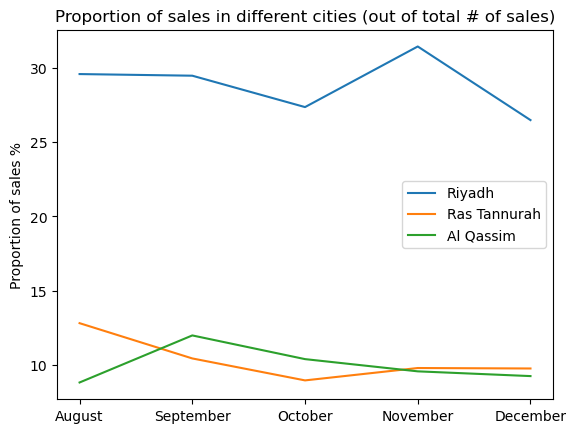

In [23]:
# plot proportion out of total number of sales
month = best_cities.index.get_level_values(0)

# make plot
sns.lineplot(x=month, y=best_cities.proportion*100, hue=best_cities.buyer_city)

plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities (out of total # of sales)")

### Could the graph look different for proportion of total sales values? 

In [24]:
def get_month_precentages(column = 'grand_total', sum_or_count = 'sum', groupby = ['month', 'buyer_city']):
    
    #new
    city_month = transactions.groupby(groupby).sum()[[column]]

    city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x / x.sum())

    # city_month_pctgs.groupby('month').sort_values()
    city_month_pctgs
    
    
    # old

    city_month = transactions.groupby(['month', 'buyer_city']).sum()['grand_total']
    months_unique = city_month_pctgs.index.unique(level='month')
    index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])

    props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)

    for month in months_unique:
        count = 0
        for i in range(N_FIRST):
            proportion_city = city_month_pctgs.loc[month].sort_values(by=column, ascending=False).iloc[i]
            
            props.loc[(month, i), 'buyer_city'] = proportion_city.name
            props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]

    return props    
    
best_cities = get_month_precentages()
best_cities['proportion'] = best_cities.proportion.astype('float')
best_cities

buyer_city  proportion
8  0        Riyadh    0.290129
   1  Ras Tannurah    0.104120
   2        Skakah    0.091770
9  0        Riyadh    0.318622
   1  Ras Tannurah    0.108217
   2     Al Qassim    0.105666
10 0        Riyadh    0.279204
   1     Al Qassim    0.108344
   2  Ras Tannurah    0.095646
11 0        Riyadh    0.311680
   1  Ras Tannurah    0.102326
   2     Al Qassim    0.085700
12 0        Riyadh    0.265461
   1  Ras Tannurah    0.104183
   2     Al Qassim    0.080645

Text(0.5, 1.0, 'Proportion of sales in different cities (total value in SR)')

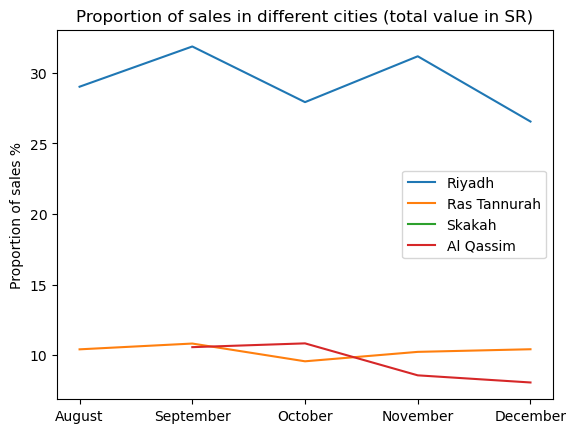

In [25]:
# calculate proportion of sales made outside the top 3 cities
# other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())
month = best_cities.index.get_level_values(0)

# make plot
sns.lineplot(x=month, y=best_cities.proportion*100, hue=best_cities.buyer_city)
# plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities (total value in SR)")

## Result 4: Average time between registration date and purchase date


In [26]:
# filter out purchases other than the first purchase
first_purchase_df = transactions.loc[~ transactions.duplicated(subset="buyer_phone", keep='first')]
first_purchase_df.shape

(2138, 8)

In [27]:
# join transactions with customers dataframes
joined_df = first_purchase_df.merge(customers, left_on="buyer_phone", right_on="customer_phone", how="inner", suffixes=['_purchased', '_customer'])
joined_df.head()

,ID_purchased,date,status,buyer_phone,buyer_city,grand_total,month,day,ID_customer,customer_phone,createdDate,lastLoginDate
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950,8,19,3497,536047743,17/08/2025T22:39:34.834Z,18/08/2025T13:09:42.971Z
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525,8,19,3051,555755225,16/08/2025T16:17:01.168Z,19/08/2025T16:14:37.322Z
2,5,2025-08-19,Transferred,558411024,Abha,12671.100,8,19,3645,558411024,18/08/2025T14:10:21.515Z,19/08/2025T19:04:20.269Z
3,7,2025-08-19,Transferred,544920156,Skakah,14136.000,8,19,2039,544920156,13/08/2025T20:06:50.206Z,19/08/2025T22:09:44.761Z
4,10,2025-08-21,Transferred,569281258,Makkah,6498.000,8,21,5093,569281258,21/08/2025T07:47:07.708Z,26/08/2025T10:49:37.445Z


In [28]:
joined_df.shape[0] / first_purchase_df.shape[0]

0.8685687558465855

### More than 10% of customers in the transactions dataframe can't be found in the customers dataframe! 

In [29]:
# fix date encoding
joined_df['createdDate'] = pd.to_datetime(joined_df.createdDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df['lastLoginDate'] = pd.to_datetime(joined_df.lastLoginDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1856
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID_purchased    1857 non-null   int64         
 1   date            1857 non-null   datetime64[ns]
 2   status          1857 non-null   object        
 3   buyer_phone     1857 non-null   int64         
 4   buyer_city      1857 non-null   object        
 5   grand_total     1857 non-null   float64       
 6   month           1857 non-null   int64         
 7   day             1857 non-null   int64         
 8   ID_customer     1857 non-null   int64         
 9   customer_phone  1857 non-null   int64         
 10  createdDate     1857 non-null   datetime64[ns]
 11  lastLoginDate   1857 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(6), object(2)
memory usage: 188.6+ KB


In [30]:
# calculate average time between registration and purchase
time_until_purchase = joined_df.date - joined_df.createdDate 
joined_df['time_until_purchase'] = time_until_purchase
avg = joined_df['time_until_purchase'].mean()
print(f"The average time between registration and purchase is {avg}")

The average time between registration and purchase is 64 days 20:44:29.853971459


## Result 4.1: On average customers take 64 days after registring to make a purchase.

Text(0.5, 0, 'time_until_purchase')

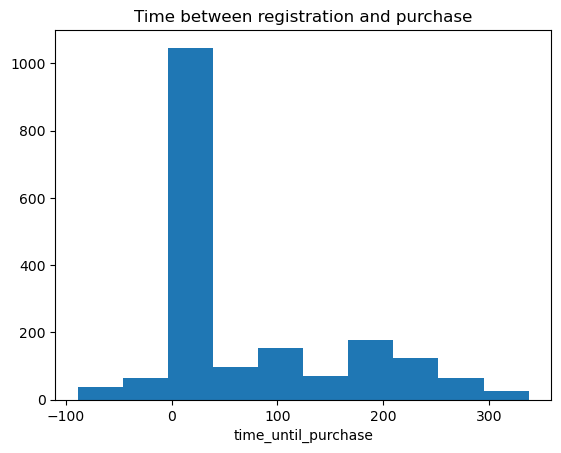

In [31]:
time_until_purchase_days = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
plt.hist(time_until_purchase_days, bins=10)
plt.title("Time between registration and purchase")
plt.xlabel("time_until_purchase")

### If we zoom in into the data, we see that that the distribution of time_until_purchase isn't normal.

Text(0.5, 0, 'Time until purchase')

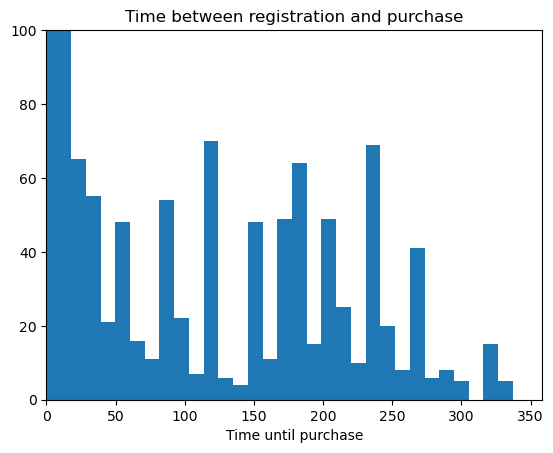

In [32]:
time_until_purchase_days = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
plt.hist(time_until_purchase_days, bins=40)
plt.title("Time between registration and purchase")
plt.ylim(top=100)
plt.xlim(0)
plt.xlabel("Time until purchase")

### Result 4.2: Data quality issues exist in the two dataframes; xxx % of customers take zero or less second to make a purchase.

In [33]:
float((time_until_purchase_days <= 0).sum()) / float(time_until_purchase_days.count())

0.17501346257404415

### Result 4.3: Registration dayofweek has a significant effect on the time_until_purchase. 

Text(0.5, 1.0, 'Registration Day of Week Effect on Time Until Purchase')

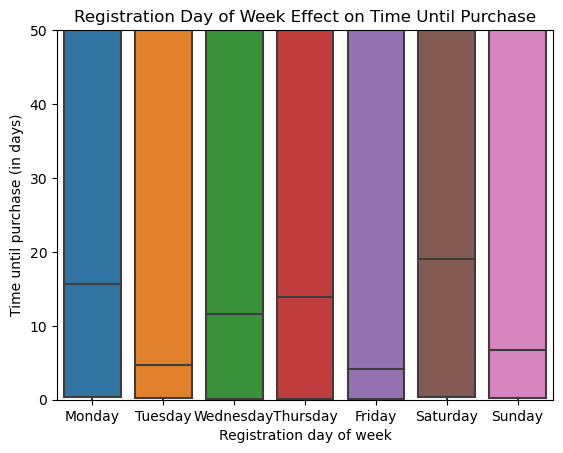

In [34]:
# date of signing up and time until purchase

dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]

sns.boxplot(x=dayofweek, y=time_until_purchase)
plt.ylim((0, 50) )
plt.xticks([0,1,2,3,4,5,6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel("Time until purchase (in days)")
plt.xlabel("Registration day of week")
plt.title("Registration Day of Week Effect on Time Until Purchase")

In [35]:
# create a transactions df that has makes_second_purchase rate
purchase_customer = purchase_df.merge(customers, 'right', left_on='buyer_phone', right_on='customer_phone')

purchase_customer['registration_year'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.year)
purchase_customer['registration_month'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.month)
purchase_customer['registration_day'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.day)
purchase_customer['registration_dayofweek'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.dayofweek)

purchase_customer['registration_year_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().year)
purchase_customer['registration_month_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().month)
purchase_customer['registration_day_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)

purchase_customer.head()

,ID_x,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,purchase_1_status,...,customer_phone,createdDate,lastLoginDate,registration_year,registration_month,registration_day,registration_dayofweek,registration_year_hijri,registration_month_hijri,registration_day_hijri
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z,2025,1,8,2,1446,7,8
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z,2025,1,8,2,1446,7,8
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z,2025,1,8,2,1446,7,8
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z,2025,1,8,2,1446,7,8
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z,2025,1,8,2,1446,7,8


### Result 4.4: A very high percentage of new customers are converted into paying customers during August (start of new school year).

Text(0, 0.5, 'Conversion rate: % of new users who bought a device')

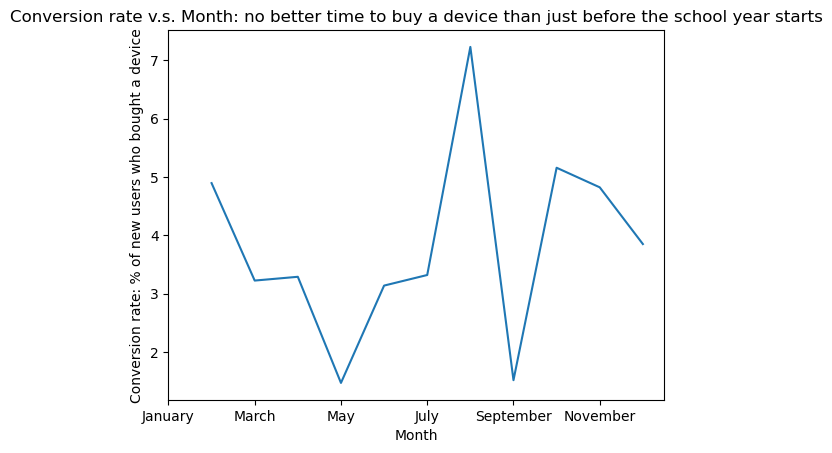

In [41]:
months_conversion = purchase_customer.groupby('registration_month').apply(lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))
sns.lineplot(x=pd.Series(purchase_customer.registration_month.unique()).sort_values(), y=months_conversion)
plt.title("Conversion rate v.s. Month: no better time to buy a device than just before the school year starts")
plt.xticks([1,3,5,7,9,11], ['January', 'March', 'May', 'July',
                                         'September', 'November'])
plt.xlabel("Month")
plt.ylabel("Conversion rate: % of new users who bought a device")



### Result 4.5: Concentrate marketing efforts on advertising on Thursday and Friday

Text(0, 0.5, 'Conversion rate: % of new users who bought a device')

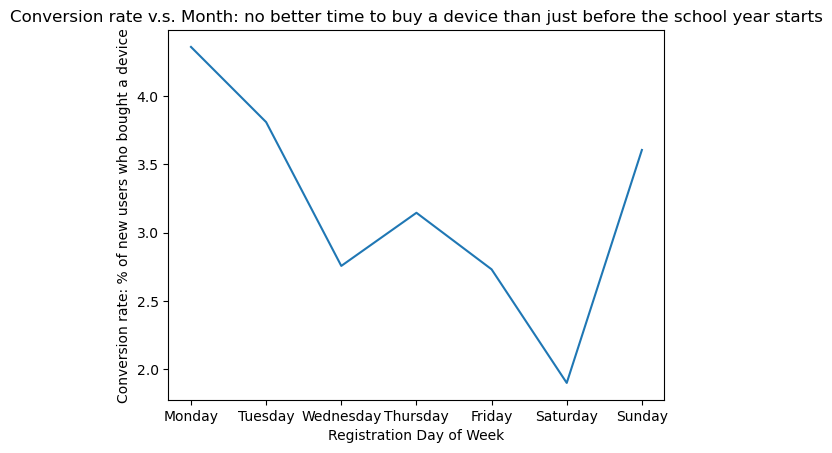

In [44]:
months_conversion = purchase_customer.groupby('registration_dayofweek').apply(
    lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))

sns.lineplot(x=pd.Series(purchase_customer.registration_dayofweek.unique()).sort_values(), y=months_conversion)
plt.title("Conversion rate v.s. Month: no better time to buy a device than just before the school year starts")

# plt.xticks([1,3,5,7,9,11], ['January', 'March', 'May', 'July',
#                                          'September', 'November'])
plt.xlabel("Registration Day of Week")
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.ylabel("Conversion rate: % of new users who bought a device")


Text(0, 0.5, 'Conversion rate: % of new users who bought a device')

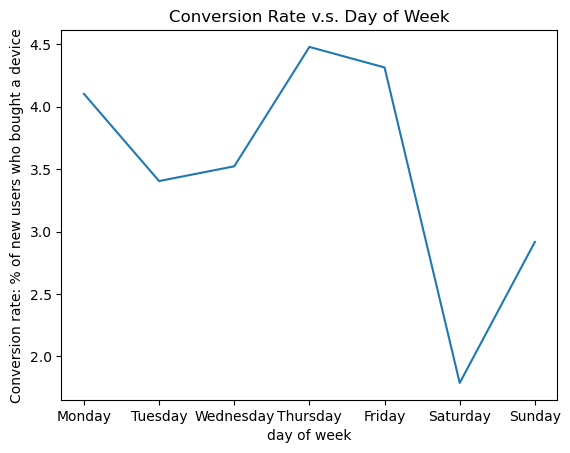

In [43]:
# get conversion rate for different days of week (filter customers who 
# registered before July because no sales were made before)
dayofweek_conversion = purchase_customer.query("registration_month > 7").groupby('registration_dayofweek').apply(
    lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))


sns.lineplot(x=pd.Series(purchase_customer.registration_dayofweek.unique()).sort_values(), y=dayofweek_conversion)
plt.title("Conversion Rate v.s. Day of Week")

plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel("day of week")
plt.ylabel("Conversion rate: % of new users who bought a device")



In [39]:
# old ********************************
def get_month_growth(column = 'grand_total', sum_or_count = 'sum', groupby = ['buyer_city', 'month']):
    
    city_month = transactions.groupby(groupby).sum()[[column]]
    city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x[column].pct_change())

    props = city_month_pctgs
    props = props.reset_index(level=0)
    return props    
    
# best_cities = get_month_growth()
# best_cities

### Result 4.6: There's a general trend toward lower growth rates in rerms of sales
- There are two clusters of cities: those whose growth rates went up on October, and those whose growth rates went down as shown above (cities not shown in the plot also belong to the same two clusters)

Text(0.5, 1.0, 'Growth in sales total value')

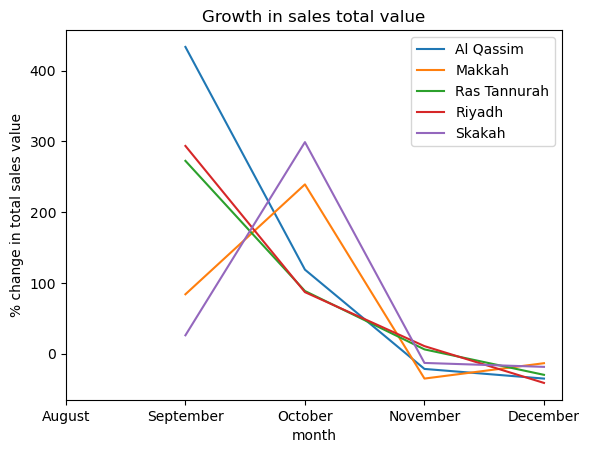

In [40]:
# calculate proportion of sales made outside the top 3 cities
# other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())
best_cities = get_month_growth()
month = best_cities.index.get_level_values('month')
buyer_city = best_cities.index.get_level_values('buyer_city')
important_cities = list(transactions.groupby('buyer_city').sum()['grand_total'].sort_values(ascending=False)[0:N_FIRST+2].index)
best_cities = best_cities.loc[best_cities.buyer_city.apply(lambda x: x in important_cities)]
month = best_cities.index.get_level_values('month')
buyer_city = best_cities.index.get_level_values('buyer_city')
# make plot
sns.lineplot(x=month, y=best_cities.grand_total*100, hue=best_cities.buyer_city)
# plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("% change in total sales value")
plt.title("Growth in sales total value")

### 

## Result 5: Actionable insights:

1. Targeted marketing for customers who have recently purchased and returned an item 
    i. They are slightly more likely (5%) to make an additional purchase. (Result 2.2)
    ii. They are much less likely to return the next item they purchase (50% v.s. 65%). (Result 2.3)  
2. Concentrate marketing to August and January (7% v.s. 2.5% average conversion rate) (Result 4.4)
3. Selectivly choose to market on Thursday and Friday (4.5% v.s. 2.5% average conversion rate) (Result 4.5)
4. Identify the characteristics/reasons for the two clusters that contain those cities whose growth rate droped significantly during October, and those cities who saw an increase in growth rare. (300% v.s. 25% growth rate ) (Result 4.6)